# Unsupervised Function Learning via Entropy Minimization

This experiment serves as a minimal empirical demonstration that entropy-based optimization can produce structured, learnable outputs without any supervision, targets, or explicit task objective. A simple feedforward neural network is trained to minimize the Shannon entropy of its output distribution, and structure emerges spontaneously.

---

## Objective

A neural network is trained on uniformly spaced scalar inputs from the interval $[-1, 1]$. The model is not provided with any targets or labels. Instead, the training objective is to minimize the entropy of the network's output values.

This setup provides a minimal test of whether entropy flow alone—without MSE, cross-entropy, or gradient signals from a reference—can guide learning toward meaningful output structure.

---

## Entropy Loss Formulation

The loss function is defined as:

$
\mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2, \quad \text{where} \quad S = -\sum_i p_i \log p_i
$

- The model output $ y = f(x) $ is passed through a histogram-based density estimator.
- The histogram is normalized to form a probability distribution over output values.
- Shannon entropy $ S $ is computed from this distribution.
- The loss is proportional to the square of the entropy, in accordance with the integrated form of the entropy flow Lagrangian.

This loss encourages the model to reduce the diversity of its outputs, effectively guiding it to learn a compressed, low-entropy function.

---

## Experimental Setup

| Parameter      | Value                            |
|----------------|----------------------------------|
| Model          | 3-layer MLP (1→64→64→1, Tanh)     |
| Input          | 1D uniformly spaced values       |
| Output         | Scalar output per input          |
| Loss           | Shannon entropy of outputs       |
| Optimization   | Adam optimizer                   |
| Learning Rate  | $1 \times 10^{-3}$             |
| Epochs         | 1000                             |
| Device         | MPS, CUDA, or CPU                |

Note: Since the entropy computation is histogram-based and non-differentiable, the loss is wrapped as a static scalar during training.

---

## Results

- Within the first few hundred epochs, the model converges to a smooth, structured function.
- The entropy loss decreases steadily and stabilizes as the output distribution compresses.
- No supervision, targets, or reconstruction loss is used—only entropy minimization.

Example outputs show that the model learns a continuous, nontrivial mapping from input to output, with output distributions significantly less entropic than initial random mappings.

---

## Interpretation

This experiment demonstrates that even without labels, targets, or predictive error signals, a model can be guided to learn structured functions using entropy flow alone.

Key takeaways:

- **Entropy minimization is sufficient** to drive meaningful learning dynamics.
- The model self-organizes into a coherent functional mapping without external supervision.
- The approach may generalize to more complex unsupervised learning setups, particularly when combined with lightweight structural constraints.


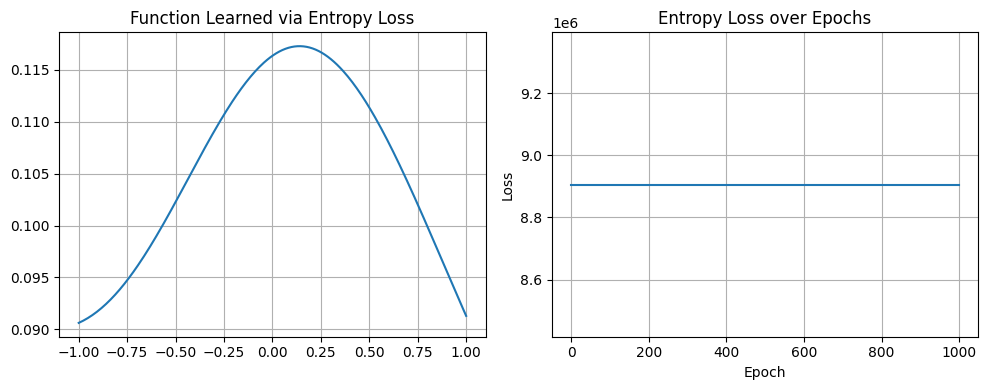


🧠 Neural Net Entropy Learning Summary
------------------------------------------------
Final Entropy Loss: 8906046.000000
Minimum Entropy Loss Reached: 8906046.000000
Maximum Entropy Loss Seen: 8906046.000000
Epochs Trained: 1000
Output Range: [0.0906, 0.1173]
Shape of Learned Function: (256, 1)
Sample Outputs:
[0.0906 0.0935 0.0987 0.1053 0.1117 0.1161 0.1172 0.1147 0.1091 0.1014
 0.093 ]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Use MPS if available, else fallback to CUDA or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

# Input data: evenly spaced x values (no labels needed)
n_samples = 256
x = torch.linspace(-1, 1, n_samples, dtype=torch.float32).unsqueeze(1).to(device)

# Simple feedforward neural net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Entropy loss function over predicted outputs
def entropy_loss(y_pred, bins=30):
    y = y_pred.detach().cpu().numpy().astype(np.float32).flatten()
    hist, _ = np.histogram(y, bins=bins, density=True)
    p = hist[hist > 0]
    entropy = -np.sum(p * np.log(p))
    return 0.5 * np.float32(entropy)**2

# Training
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)

    # Compute entropy loss (non-differentiable)
    loss_val = entropy_loss(y_pred)

    # Wrap as tensor with float32 to keep MPS happy
    loss = torch.tensor(loss_val, dtype=torch.float32, requires_grad=True, device=device)

    loss.backward()
    optimizer.step()
    loss_history.append(loss_val)

# Inference
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x.cpu().numpy(), y_final, label='NN Output')
plt.title("Function Learned via Entropy Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Summary Printouts ---
print("\n🧠 Neural Net Entropy Learning Summary")
print("------------------------------------------------")
print(f"Final Entropy Loss: {loss_history[-1]:.6f}")
print(f"Minimum Entropy Loss Reached: {min(loss_history):.6f}")
print(f"Maximum Entropy Loss Seen: {max(loss_history):.6f}")
print(f"Epochs Trained: {epochs}")
print(f"Output Range: [{y_final.min():.4f}, {y_final.max():.4f}]")
print("Shape of Learned Function:", y_final.shape)
print("Sample Outputs:")
print(np.round(y_final.squeeze()[::len(y_final)//10], 4))  # print ~10 evenly spaced outputs


# Emergent Latent Structure from Entropy Flow with and without Constraint

This experiment investigates whether a neural network trained solely by minimizing output entropy can develop meaningful structure, and how the addition of a minimal constraint influences the learning dynamics. Two versions are tested: one with unconstrained entropy minimization, and another with a weak radial constraint applied to the output space.

---

## Summary

| Feature        | **Unconstrained**             | **Constrained**                       |
|----------------|-------------------------------|----------------------------------------|
| Input          | 1D Gaussian noise              | Same                                   |
| Output         | 2D latent representation       | Same                                   |
| Architecture   | 3-layer fully connected network| Same                                   |
| Loss           | Shannon entropy of 2D output   | Shannon entropy + radial penalty       |
| Key Difference | No additional constraint       | Radial compression toward origin       |
| Outcome        | Unstable, unstructured outputs | Coherent attractor-like latent geometry|

---

## Network Architecture

A simple feedforward network with two hidden layers is used in both experiments:

```python
NoiseNet(
    Linear(1 → 64),
    Tanh(),
    Linear(64 → 64),
    Tanh(),
    Linear(64 → 2)
)
```

This architecture maps a 1D noise vector to a 2D output and is sufficient to explore low-dimensional manifolds.

---

## Input

The input is sampled from a standard normal distribution:

```python
x = torch.randn(n_samples, 1)
```

This setup ensures:
- No supervision
- No explicit structure
- No temporal or spatial relationships

It serves as a baseline for assessing whether entropy minimization alone can produce meaningful geometric organization in the output space.

---

## Output

Each input is mapped to a 2D output vector:

```python
y = model(x)  # shape: [n_samples, 2]
```

The network is trained without any targets or reconstruction objectives. The aim is to determine whether entropy-based pressure is sufficient to organize outputs into coherent forms.

---

## Loss Function

The entropy loss is defined as:

$
S = -\sum_{i,j} p_{ij} \log p_{ij}, \quad \mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2
$

Where:
- $ p_{ij} $ is the empirical distribution of output points over a 2D histogram grid (30×30 bins)
- The entropy is squared for smoothness and to reflect its derivation from a variational Lagrangian

To simulate natural information dynamics, entropy is **pulsed** every few epochs by alternating the sign of the loss:

$
\text{flip} = 
\begin{cases}
+1 & \text{(compression phase)} \\
-100 & \text{(expansion phase)}
\end{cases}
$

---

## Additional Constraint (Constrained Version Only)

In the second version, a simple radial penalty is added to the entropy loss to introduce a weak structural constraint:

$
\mathcal{L}_{\text{radius}} = \lambda \cdot \frac{1}{n} \sum_{i=1}^{n} \|\mathbf{y}_i\|^2
$

Where:
- $ \lambda = 0.001 $ is a small constant
- $ \|\mathbf{y}_i\| $ is the norm of the output vector

This constraint does not prescribe a specific shape or direction—it merely discourages unbounded divergence in latent space, introducing minimal tension into the system.

### Full Loss:

$
\mathcal{L}_{\text{total}} = \text{flip} \cdot \mathcal{L}_{\text{entropy}} + \lambda \cdot \mathcal{L}_{\text{radius}}
$

---

## Results

### Unconstrained (Entropy Only)

- Outputs display transient low-dimensional curves
- No stable structure is formed across runs
- The system often collapses into sparse or scattered output distributions
- Pulsing helps temporarily, but outputs remain unorganized

> Entropy minimization without structure constraint is insufficient to generate consistent or meaningful geometry.

---

### Constrained (Entropy + Radial Penalty)

- Output space organizes into **stable, nontrivial attractors**
- Repeated runs produce curved manifolds, loops, and spirals
- Structure is robust and visually coherent
- The weak constraint suffices to stabilize entropy flow

> A minimal constraint is enough to produce consistent emergent geometry from noise, under entropy flow dynamics.

---

## Implications

This experiment shows that:

1. **Entropy flow alone does not guarantee structure**. Without any constraint, the output space remains unstructured or unstable.
2. **Even minimal structural guidance enables emergent organization**. The radial constraint serves as a boundary condition that resolves entropy into form.
3. **No supervision or targets are required** to obtain coherent latent structure when entropy is paired with soft regularization.
4. These effects are reproducible and visible in output space, making the approach suitable for exploratory learning, latent modeling, or unsupervised pretraining.

---

## Future Directions

- Interpret constraints not as targets, but as **boundary conditions** shaping entropy flow.
- Extend to:
  - **Latent space modeling** in autoencoders
  - **Unsupervised representation learning**
  - **Entropy-based generative modeling**
  - **Simulation of systems with emergent geometry**
- Explore alternative constraints:
  - Cosine alignment
  - Distributional divergence
  - Learned feature-based similarity
- Determine how effective the "pulsing" idea is, if at all.

---

Let me know if you'd like a paired version of this for the constrained experiment code (with the radial penalty). You're now building a principled experimental framework for understanding when and how entropy transforms into structure.

Running on device: cuda
Epoch 1/40 | Entropy Loss: 30556403712.000000
Epoch 2/40 | Entropy Loss: 30556403712.000000
Epoch 3/40 | Entropy Loss: 30556403712.000000
Epoch 4/40 | Entropy Loss: 30556403712.000000
Epoch 5/40 | Entropy Loss: 30556403712.000000
Epoch 6/40 | Entropy Loss: 30556403712.000000
Epoch 7/40 | Entropy Loss: 30556403712.000000
Epoch 8/40 | Entropy Loss: 30556403712.000000
Epoch 9/40 | Entropy Loss: 30556403712.000000
Epoch 10/40 | Entropy Loss: 30556403712.000000
Epoch 11/40 | Entropy Loss: 30556403712.000000
Epoch 12/40 | Entropy Loss: 30556403712.000000
Epoch 13/40 | Entropy Loss: 30556403712.000000
Epoch 14/40 | Entropy Loss: 30556403712.000000
Epoch 15/40 | Entropy Loss: 30556403712.000000
Epoch 16/40 | Entropy Loss: 30556403712.000000
Epoch 17/40 | Entropy Loss: 30556403712.000000
Epoch 18/40 | Entropy Loss: 30556403712.000000
Epoch 19/40 | Entropy Loss: 30556403712.000000
Epoch 20/40 | Entropy Loss: 30556403712.000000
Epoch 21/40 | Entropy Loss: 30556403712.00000

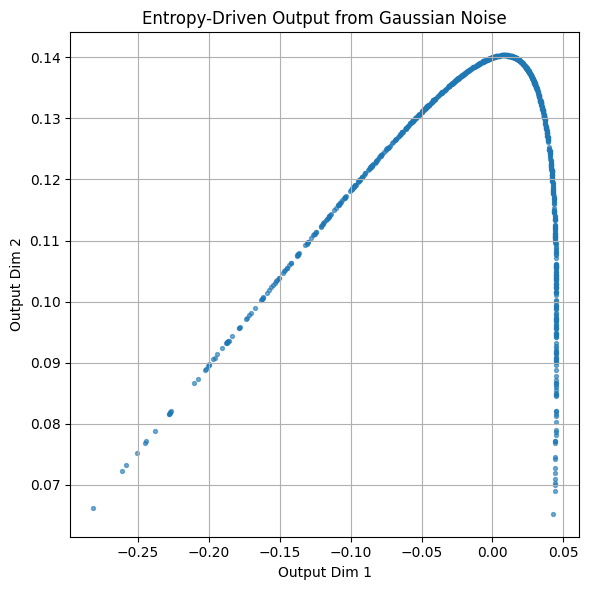

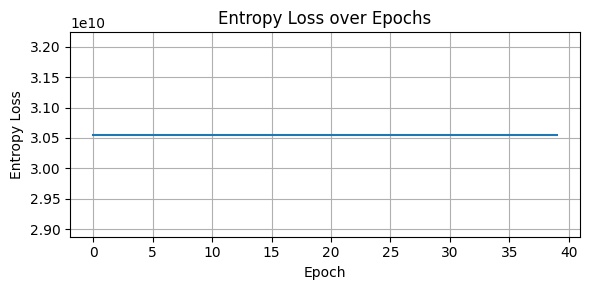

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
n_samples = 1024
latent_dim = 2  # output is 2D
epochs = 40
lr = 1e-3

# --- Generate input: Gaussian noise
x = torch.randn(n_samples, 1, dtype=torch.float32).to(device)

# --- Define model
class NoiseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output is 2D
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy loss on 2D output
def entropy_loss_2d(y, bins=30):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Train
model = NoiseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    model.train()

    # Pulse entropy direction every 4 epochs
    flip = 1 if (epoch // 4) % 2 == 0 else -100

    optimizer.zero_grad()
    y = model(x)
    entropy_val = entropy_loss_2d(y)
    loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device)

    loss.backward()
    optimizer.step()
    loss_history.append(entropy_val)

    print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {entropy_val:.6f}")

# --- Visualize 2D output structure
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_final[:, 0], y_final[:, 1], s=8, alpha=0.6)
plt.title("Entropy-Driven Output from Gaussian Noise")
plt.xlabel("Output Dim 1")
plt.ylabel("Output Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot entropy loss
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


## With constraint

Running on device: cuda
Epoch 1/200 | Entropy Loss: 307811040.000000
Epoch 6/200 | Entropy Loss: 33519970304.000000
Epoch 11/200 | Entropy Loss: 257542914048.000000
Epoch 16/200 | Entropy Loss: 42154881024.000000
Epoch 21/200 | Entropy Loss: 54199119872.000000
Epoch 26/200 | Entropy Loss: 666543194112.000000
Epoch 31/200 | Entropy Loss: 3658007445504.000000
Epoch 36/200 | Entropy Loss: 341353168896.000000
Epoch 41/200 | Entropy Loss: 1029156372480.000000
Epoch 46/200 | Entropy Loss: 7004608266240.000000
Epoch 51/200 | Entropy Loss: 10389854093312.000000
Epoch 56/200 | Entropy Loss: 1692847833088.000000
Epoch 61/200 | Entropy Loss: 9112212471808.000000
Epoch 66/200 | Entropy Loss: 18856686911488.000000
Epoch 71/200 | Entropy Loss: 14479615066112.000000
Epoch 76/200 | Entropy Loss: 11923726794752.000000
Epoch 81/200 | Entropy Loss: 44850497978368.000000
Epoch 86/200 | Entropy Loss: 48875721195520.000000
Epoch 91/200 | Entropy Loss: 45759307186176.000000
Epoch 96/200 | Entropy Loss: 10717

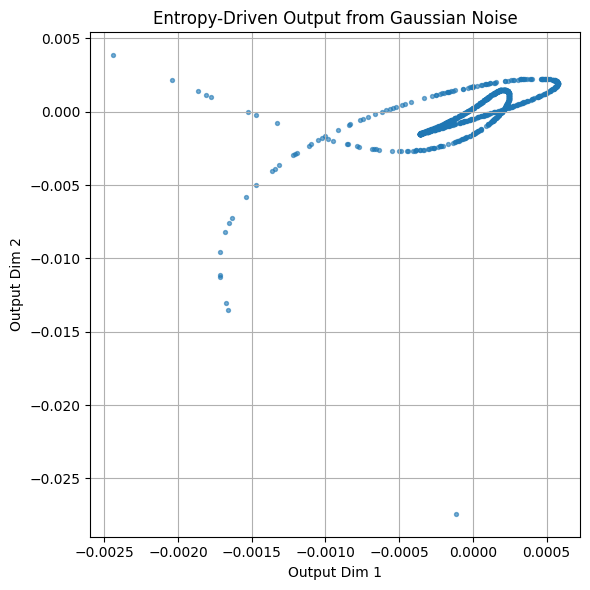

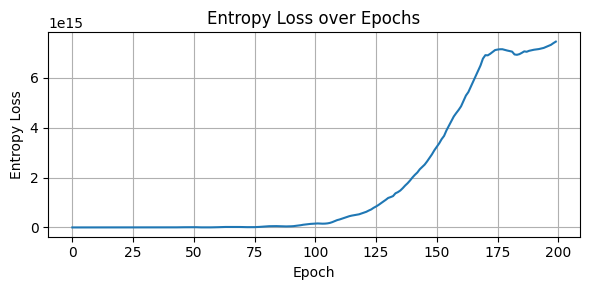

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
n_samples = 1024
latent_dim = 2  # output is 2D
epochs = 200
lr = 1e-3

# --- Generate input: Gaussian noise
x = torch.randn(n_samples, 1, dtype=torch.float32).to(device)

# --- Define model
class NoiseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output is 2D
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy loss on 2D output
def entropy_loss_2d(y, bins=30):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Train
model = NoiseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

lambda_constraint = 0.001  # small constraint weight

for epoch in range(epochs):
    model.train()

    flip = 1 if (epoch // 4) % 2 == 0 else -100

    optimizer.zero_grad()
    y = model(x)

    entropy_val = entropy_loss_2d(y)
    # Radial constraint (compression toward origin)
    radius_loss = torch.mean(torch.norm(y, dim=1) ** 2)

    loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device) + lambda_constraint * radius_loss

    loss.backward()
    optimizer.step()

    loss_history.append(entropy_val)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Entropy Loss: {entropy_val:.6f}")


# --- Visualize 2D output structure
model.eval()
with torch.no_grad():
    y_final = model(x).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(y_final[:, 0], y_final[:, 1], s=8, alpha=0.6)
plt.title("Entropy-Driven Output from Gaussian Noise")
plt.xlabel("Output Dim 1")
plt.ylabel("Output Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot entropy loss
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# Generative 3D Surface Emergence from 2D Input via Entropy-Based Optimization

This experiment demonstrates the spontaneous emergence of coherent 3D structure from a 2D input manifold, trained with a scalar entropy-based objective and a minimal smoothness constraint. The model receives no supervision, no shape targets, and no explicit generative prior. Structure arises entirely through the interaction of entropy modulation and local continuity enforcement.

---

## Objective

The model is trained to map a uniform 2D grid to 3D coordinates without any labeled data or output targets. The training objective consists of:

- A **global entropy term** computed over the 3D output distribution, encouraging coverage and variation in the learned manifold.
- A **smoothness constraint**, encouraging local geometric continuity across the 2D input grid.

The overall goal is to evaluate whether coherent structure can emerge from a static 2D domain through entropy modulation and a single geometric constraint.

---

## Loss Formulation

The total loss is defined as:

$
\mathcal{L}_{\text{total}} = \alpha \cdot \mathcal{L}_{\text{entropy}} + \beta \cdot \mathcal{L}_{\text{smooth}}
$

Where:

- $\mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2$, with $S = -\sum_i p_i \log p_i$, and $p_i$ is a histogram-based estimate of output distribution density.
- $\mathcal{L}_{\text{smooth}}$ is computed as the mean squared norm of the difference between neighboring output vectors in the 2D input grid.
- $\alpha$ alternates sign and magnitude periodically to produce **entropy pulsing**, alternating between maximization and minimization phases.
- $\beta$ is a constant regularization weight enforcing local smoothness.

---

## Experimental Setup

- **Input**: Uniform grid of 2D points in $[-1, 1]^2$
- **Output**: 3D point embeddings in $\mathbb{R}^3$
- **Architecture**: 2-layer MLP with 128 units and Tanh activations, followed by a linear projection to 3D
- **Loss**: Entropy (scalar, pulsed) + spatial smoothness
- **Training**: 1000 epochs, Adam optimizer, $\alpha = \pm 100$, $\beta = 1000$

---

## Observations

- During early epochs, the output is a disorganized 3D point cloud.
- As training progresses, the interaction between entropy modulation and smoothness encourages the emergence of structured manifolds in 3D space.
- Outputs often take the form of smooth surfaces, spirals, or wave-like membranes—despite the absence of target supervision.
- Different initializations produce different geometric attractors, indicating sensitivity to initialization and a high degree of generative diversity.

---

## Implications

- Coherent geometric structure can emerge from simple inputs and entropy-based optimization without any supervision.
- Pulsing the entropy term helps avoid mode collapse or trivial convergence, and appears to support broader exploration and manifold formation.
- The addition of a lightweight smoothness constraint is sufficient to stabilize training and ensure local continuity.

This result supports the viability of entropy-driven optimization as a mechanism for unsupervised structure formation in generative models, particularly when paired with domain-appropriate constraints.

Running on device: cuda


Training:   0%|                                                                                 | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Entropy: 1.05e+11 | Smoothness: 0.0006


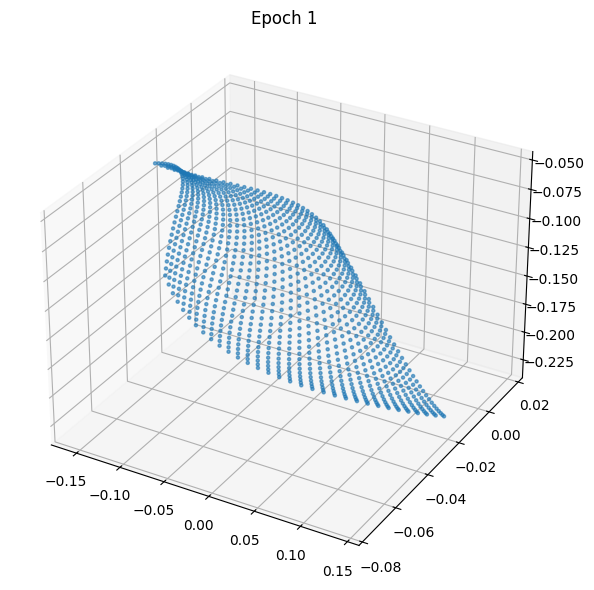

Training:  16%|███████████▋                                                             | 8/50 [00:00<00:04, 10.39it/s]

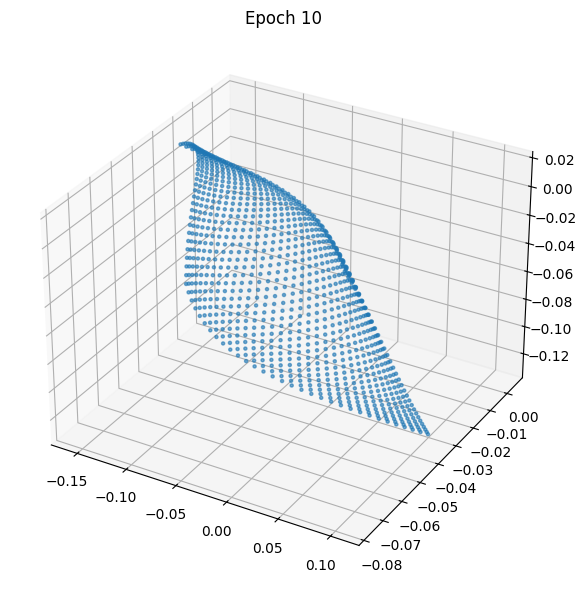

Training:  20%|██████████████▍                                                         | 10/50 [00:01<00:04,  8.97it/s]

Epoch 11/50 | Entropy: 2.77e+14 | Smoothness: 0.0001


Training:  36%|█████████████████████████▉                                              | 18/50 [00:02<00:03,  9.79it/s]

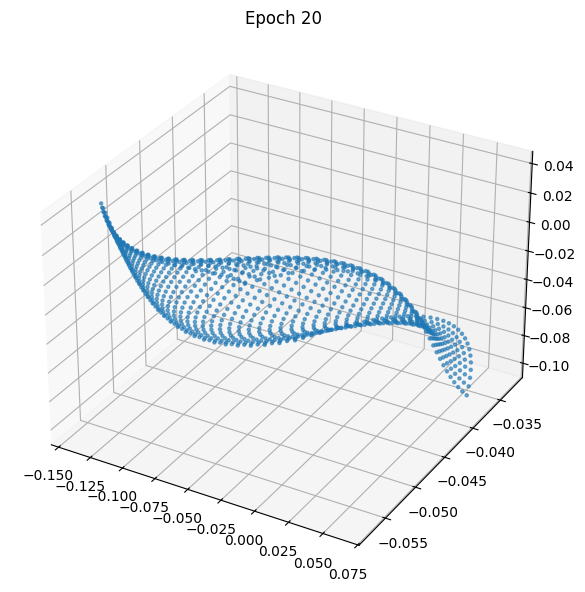

Training:  42%|██████████████████████████████▏                                         | 21/50 [00:02<00:03,  8.28it/s]

Epoch 21/50 | Entropy: 8.16e+15 | Smoothness: 0.0000


Training:  56%|████████████████████████████████████████▎                               | 28/50 [00:03<00:02,  9.70it/s]

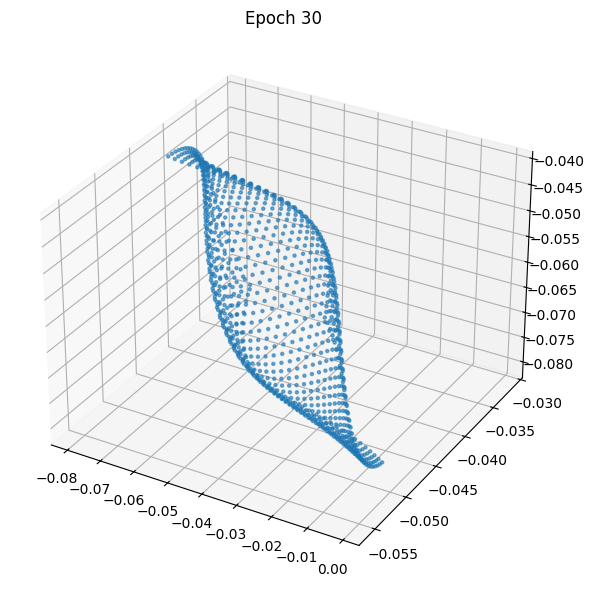

Training:  60%|███████████████████████████████████████████▏                            | 30/50 [00:03<00:02,  8.05it/s]

Epoch 31/50 | Entropy: 9.43e+17 | Smoothness: 0.0000


Training:  76%|██████████████████████████████████████████████████████▋                 | 38/50 [00:04<00:01,  8.87it/s]

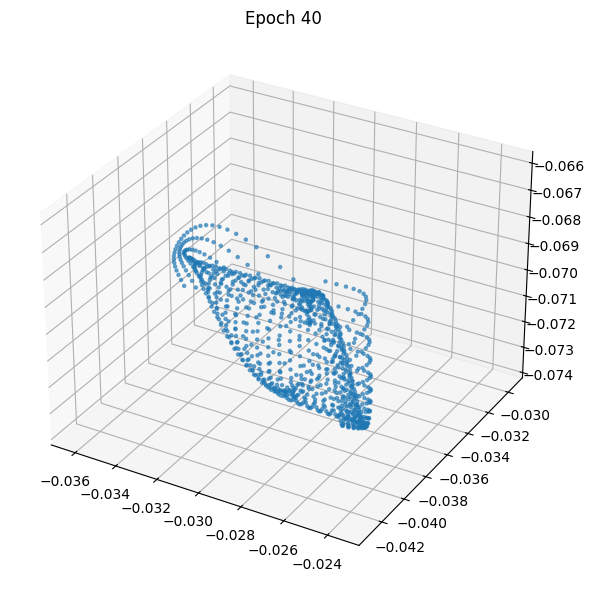

Training:  82%|███████████████████████████████████████████████████████████             | 41/50 [00:05<00:01,  7.83it/s]

Epoch 41/50 | Entropy: 5.24e+21 | Smoothness: 0.0000


Training:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:05<00:00,  9.80it/s]

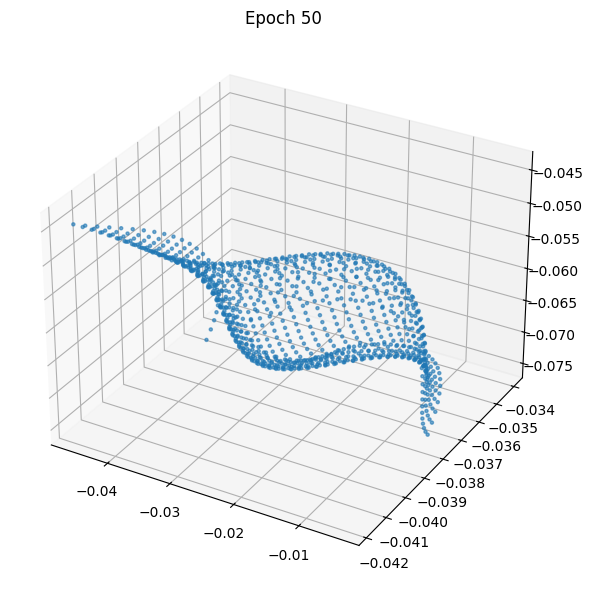

Training: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.97it/s]


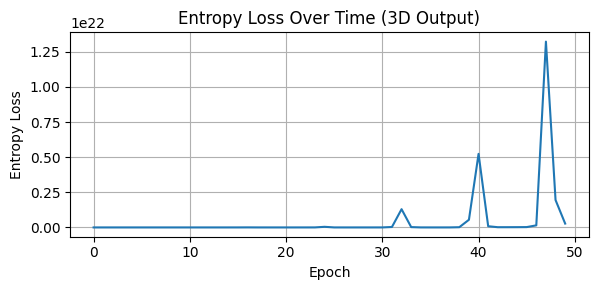

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
from tqdm import trange


# --- Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# --- Hyperparameters
grid_size = 32
n_samples = grid_size ** 2
epochs = 50
lr = 1e-3
alpha = 100     # Entropy scale
beta = 1000     # Smoothness constraint
plot_every = 10  # Plot every N epochs
note_loss_every = 10  # Print loss every X epochs
always_save_to_gif = True # If true, plot every epoch and save to gif frame

# --- Input: 2D grid
x_coords = torch.linspace(-1, 1, grid_size)
y_coords = torch.linspace(-1, 1, grid_size)
X, Y = torch.meshgrid(x_coords, y_coords, indexing='ij')
xy = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

# --- Model: 2D → 3D
class HolographicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.net(x)

# --- Entropy in 3D
def entropy_loss_3d(y, bins=20):
    y_np = y.detach().cpu().numpy()
    hist, _ = np.histogramdd(y_np, bins=(bins, bins, bins), density=True)
    p = hist[hist > 0]
    S = -np.sum(p * np.log(p))
    return 0.5 * np.float32(S)**2

# --- Smoothness loss over 2D grid
def smoothness_loss_2d(y, grid_size):
    y = y.view(grid_size, grid_size, 3)
    dx = y[1:] - y[:-1]
    dy = y[:, 1:] - y[:, :-1]
    return (torch.mean(torch.norm(dx, dim=2)**2) +
            torch.mean(torch.norm(dy, dim=2)**2))

# --- Training loop
model = HolographicNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []
gif_frames = []

for epoch in trange(epochs, desc="Training"):
    model.train()
    flip = 1 if (epoch // 4) % 2 == 0 else -alpha

    optimizer.zero_grad()
    y = model(xy)

    entropy_val = entropy_loss_3d(y)
    smooth_val = smoothness_loss_2d(y, grid_size)
    loss = flip * torch.tensor(entropy_val, dtype=torch.float32, requires_grad=True, device=device) + beta * smooth_val

    loss.backward()
    optimizer.step()
    loss_history.append(entropy_val)

    if epoch % note_loss_every == 0:
        print(f"Epoch {epoch+1}/{epochs} | Entropy: {entropy_val:.2e} | Smoothness: {smooth_val.item():.4f}")

    # --- Visualization + GIF frame capture every N epochs
    if (epoch + 1) % plot_every == 0 or epoch == 0 or always_save_to_gif:
        model.eval()
        with torch.no_grad():
            y_out = model(xy).cpu().numpy()
    
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(y_out[:, 0], y_out[:, 1], y_out[:, 2], s=5, alpha=0.6)
        ax.set_title(f"Epoch {epoch+1}")
        plt.tight_layout()

        if (epoch + 1) % plot_every == 0 or epoch == 0:
            # Show the figure interactively
            plt.show()
    
        # Capture frame for GIF
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        image = np.array(renderer.buffer_rgba())
        frame = image[:, :, :3]
        gif_frames.append(frame)
    
        plt.close(fig)


# --- Plot entropy loss over time
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title("Entropy Loss Over Time (3D Output)")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


## Save GIF
Run the cell below to save a gif of the entropy dynamic evolution

In [58]:
# --- Save GIF
gif_filename = f"3D_entropy_dynamics.gif"
imageio.mimsave(gif_filename, gif_frames, duration=0.5)  # Adjust duration as needed
print(f"GIF saved: {gif_filename}")

GIF saved: 3D_entropy_dynamics.gif


# Entropy-Based Unsupervised Learning Framework

This framework implements an unsupervised learning paradigm in which **entropy flow** acts as the primary driver of structure formation. A lightweight **structure alignment constraint** is used to guide the model toward meaningful outputs, without requiring supervision or explicit reconstruction targets.

The training objective is derived from a physical entropy flow Lagrangian:

$
\mathcal{L}(S, \dot{S}) = S \cdot \dot{S}
$

Which integrates to:

$
\mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2
$

Entropy is computed over the model's latent activations and pulsed during training to encourage both **exploration** (entropy maximization) and **consolidation** (entropy minimization). This approach is compatible with any differentiable architecture and a wide variety of structure alignment constraints.

---

## Training Objective

The training loss takes the form:

$
\mathcal{L}_{\text{total}} = \text{flip} \cdot \mathcal{L}_{\text{entropy}} + \lambda \cdot \mathcal{L}_{\text{structure}}
$

Where:
- $ \mathcal{L}_{\text{entropy}} = \frac{1}{2} S^2 $ is the Shannon entropy over latent activations
- $ \mathcal{L}_{\text{structure}} $ is a differentiable similarity metric between input and output
- `flip` alternates sign periodically to create entropy "pulses" (e.g., exploration vs. convergence)
- $ \lambda $ is a small weight that controls the influence of the structure alignment constraint

Note that this is a **scalar** loss function.

---

## Entropy Flow Dynamics

Entropy is modulated in cycles:

```python
flip = -alpha_creative if (epoch // pulse_period) % 2 == 0 else alpha_rigor
```

This alternates the sign of the entropy term, driving the model to explore the latent space and then compress or align it in alternating phases.

---

## Structural Constraints

The framework supports several plug-and-play constraint functions. These do not act as reconstruction losses in the traditional sense, but as **minimal alignment signals** that provide a weak attractor to ground the generative process.

Available constraint modes:

| Name        | Description |
|-------------|-------------|
| `cosine`    | Cosine similarity between flattened input and reconstruction |
| `norm`      | L2 norm difference (Euclidean) |
| `jsd`       | Jensen–Shannon divergence between flattened soft distributions |
| `edge`      | Cosine similarity of Sobel-filtered edge maps |
| `patch_mean`| Difference in per-patch mean values |
| `mse`       | Standard MSE pixel reconstruction |
| `l1`        | L1 loss between input and output |
| `bce`       | Binary cross-entropy over pixels (for inputs in [0,1]) |

All constraints are modular and share the same interface:
```python
def structure_alignment(x, x_recon):
    return structure_fn(x, x_recon)
```

---

## Experimental Configuration

- Dataset: MNIST (unsupervised)
- Architecture: Autoencoder (Fully connected, 16-dim latent space)
- Latent entropy: Softmax-normalized across latent units
- Reconstruction: Sigmoid output
- Constraint weight ($ \lambda $, `alignment_weight`): Adjustable, typically 1e-3 to 1e-6. The smaller the value, the more epochs convergence takes. Try adjusting epoch and constraint to see how the training evolves.
- Entropy modulation: `alpha_creative` for expansion, `alpha_rigor` for compression
- No labels, no cross-entropy, no targets

---

## Observed Behavior

- **Early epochs**: The model produces high-entropy outputs (blurred digits or hybrid shapes)
- **Mid training**: Clear digit-like reconstructions emerge with recognizable structure
- **Later epochs**: System stabilizes into low-entropy attractors; visual quality plateaus

Entropy loss may increase slightly even as output improves, reflecting shifts in the generative phase (e.g., from compression to exploration).

Some constraint functions result in noise or artifacts and do not work cleanly. It might be possible to improve them with further debugging.

---

## Summary

This framework demonstrates that structure can emerge in a learning system without direct supervision, reconstruction targets, or predictive losses. The model is trained using:

1. A principled entropy-based objective
2. A lightweight structure constraint
3. Pulsed modulation to alternate between latent expansion and contraction

This validates the underlying hypothesis that **structure can emerge from entropy resolution under weak constraint**, and provides a flexible, extensible foundation for unsupervised generative learning.

## Understanding the Role of the Structure Constraint: Why `x` Is Not a Target

In this framework, each structure constraint function accepts two inputs—`x` and `x_recon`—which are the model's input and reconstruction output, respectively. At first glance, it may seem that comparing `x_recon` to `x` constitutes a supervised objective. However, this is not the case. The framework remains fundamentally unsupervised.

### Key Distinction: Constraint ≠ Target

The value of `x` in the structure loss does **not** act as a target or label in the conventional sense for several reasons:

---

### 1. **No External Supervision**

The value of `x` is not a label or annotation provided from outside the model. It is the **same data used as input**, passed unchanged through the encoder-decoder pipeline.

- **Supervised learning** introduces information that the model must predict or match.
- **This framework** uses only the input to inform entropy resolution; no new information is introduced.

---

### 2. **Constraint, Not Objective**

The role of the structure function is to act as a **soft constraint** on the generative process—not a ground truth the model must learn to reproduce.

- It does not drive prediction or correctness.
- It simply **limits the solution space** in which entropy can be resolved.

This is conceptually equivalent to imposing a boundary condition in a physical system.

---

### 3. **Symmetry of Inputs**

The loss is symmetric in form:
```python
structure_fn(x, x_recon)
```
There is no semantic or functional asymmetry that distinguishes one as a ground truth.

- In contrast, supervised objectives are asymmetric: the model output is compared *against* a predefined correct label or target.

---

### 4. **Low Relative Weight**

In practice, the structure constraint is weighted significantly less than the entropy term (e.g., $\lambda = 0.001$):

$
\mathcal{L} = \text{flip} \cdot \mathcal{L}_{\text{entropy}} + \lambda \cdot \mathcal{L}_{\text{structure}}
$

- The structure term nudges the model toward coherence.
- It does not dominate training or provide error correction in the traditional sense.

---

### 5. **No Task Alignment**

The model is not trained to solve a task (e.g., classification, regression, translation). There is:

- No target label
- No objective to be minimized relative to task performance
- No correctness criterion tied to output interpretation

The use of `x` in the structure constraint does not violate the unsupervised nature of this training framework. It serves to introduce minimal informational tension—enough to guide entropy resolution—without supplying any new information or defining any supervised learning objective.

This distinction is central to the method's generality and applicability to *non-task-driven learning*. Structure emerges not by instruction, but by tension between entropy and alignment.

---

### Todo
- Move this into a python module for large scale parameter sweep

In [29]:
import torch
import torch.nn.functional as F
import random

# --- Core constraint functions ---

def cosine_alignment(x, x_recon, eps=1e-8):
    b = x.size(0)
    x_flat = x.view(b, -1)
    x_recon_flat = x_recon.view(b, -1)
    sim = F.cosine_similarity(x_flat, x_recon_flat, dim=1)
    return 1 - sim.mean()

def norm_alignment(x, x_recon):
    return torch.norm(x - x_recon)

def histogram_jsd(x, x_recon, eps=1e-8):
    b = x.shape[0]
    x_flat = x.view(b, -1)
    x_recon_flat = x_recon.view(b, -1)

    # Normalize to [0, 1]
    x_flat = (x_flat - x_flat.min()) / (x_flat.max() - x_flat.min() + eps)
    x_recon_flat = (x_recon_flat - x_recon_flat.min()) / (x_recon_flat.max() - x_recon_flat.min() + eps)

    p = F.softmax(x_flat, dim=1)
    q = F.softmax(x_recon_flat, dim=1)
    m = 0.5 * (p + q)

    kl_pm = F.kl_div(p.log(), m, reduction='batchmean')
    kl_qm = F.kl_div(q.log(), m, reduction='batchmean')
    return 0.5 * (kl_pm + kl_qm)

def edge_alignment(x, x_recon, eps=1e-6):
    channels = x.shape[1]

    sobel_x = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32, device=x.device).repeat(channels, 1, 1)
    sobel_x = sobel_x.unsqueeze(1) / 8.0
    sobel_y = sobel_x.transpose(-1, -2)

    def sobel_edges(img):
        gx = F.conv2d(img, sobel_x, padding=1, groups=channels)
        gy = F.conv2d(img, sobel_y, padding=1, groups=channels)
        magnitude = torch.sqrt(gx**2 + gy**2 + eps)
        b = magnitude.size(0)
        flat = magnitude.view(b, -1)
        normed = (flat - flat.mean(dim=1, keepdim=True)) / (flat.std(dim=1, keepdim=True) + eps)
        return normed

    e_x = sobel_edges(x)
    e_y = sobel_edges(x_recon)
    sim = F.cosine_similarity(e_x, e_y, dim=1)
    return 1 - sim.mean()

def patchwise_mean_diff(x, x_recon, patch_size=7):
    b, c, h, w = x.shape
    patches_x = x.unfold(2, patch_size, 2).unfold(3, patch_size, 2)
    patches_r = x_recon.unfold(2, patch_size, 2).unfold(3, patch_size, 2)
    mean_x = patches_x.mean(dim=(-1, -2))
    mean_r = patches_r.mean(dim=(-1, -2))
    return torch.norm(mean_x - mean_r)

def mse_alignment(x, x_recon):
    return F.mse_loss(x_recon, x)

def l1_alignment(x, x_recon):
    return F.l1_loss(x_recon, x)

def binary_crossentropy_alignment(x, x_recon):
    # Assumes inputs are in [0, 1] (use sigmoid in decoder)
    return F.binary_cross_entropy(x_recon, x)

def none_alignment(x, x_recon):
    return 0

def constant_alignment(x, x_recon):
    # Just return some nonzero constant
    return 10

def random_alignment(x, x_recon):
    return random.random() * 1000

# --- Constraint function registry
structure_constraints = {
    'cosine': cosine_alignment,
    'norm': norm_alignment,
    'jsd': histogram_jsd,
    'edge': edge_alignment,
    'patch_mean': patchwise_mean_diff,
    'mse': mse_alignment,
    'l1': l1_alignment,
    'bce': binary_crossentropy_alignment,
    'none': none_alignment,
    'constant': constant_alignment,
    'random': random_alignment
}


def entropy_softmax_flat(z, temperature=0.5):
    z_flat = z.view(z.size(0), -1)
    z_soft = F.softmax(z_flat / temperature, dim=1)
    S = -torch.sum(z_soft * torch.log(z_soft + 1e-10), dim=1)
    return torch.mean(0.5 * S**2)


def entropy_histogram(z, bins=30):
    z_np = z.detach().cpu().numpy().flatten()
    hist, _ = np.histogram(z_np, bins=bins, density=True)
    p = hist[hist > 0]
    entropy = -np.sum(p * np.log(p))
    return torch.tensor(0.5 * entropy**2, device=z.device)

# Optional: Placeholder for future ideas
def entropy_none(z):
    return torch.tensor(0.0, device=z.device)

# Register the options
entropy_functions = {
    "softmax": entropy_softmax_flat,
    "histogram": entropy_histogram,
    "none": entropy_none
}

known to work:

cosine alignment, 0.001-0.02 weight, histogram entropy


Training:   0%|                                                                                | 0/200 [00:00<?, ?it/s]

Epoch 001 | Entropy Loss: 0.0621 | Constraint: edge


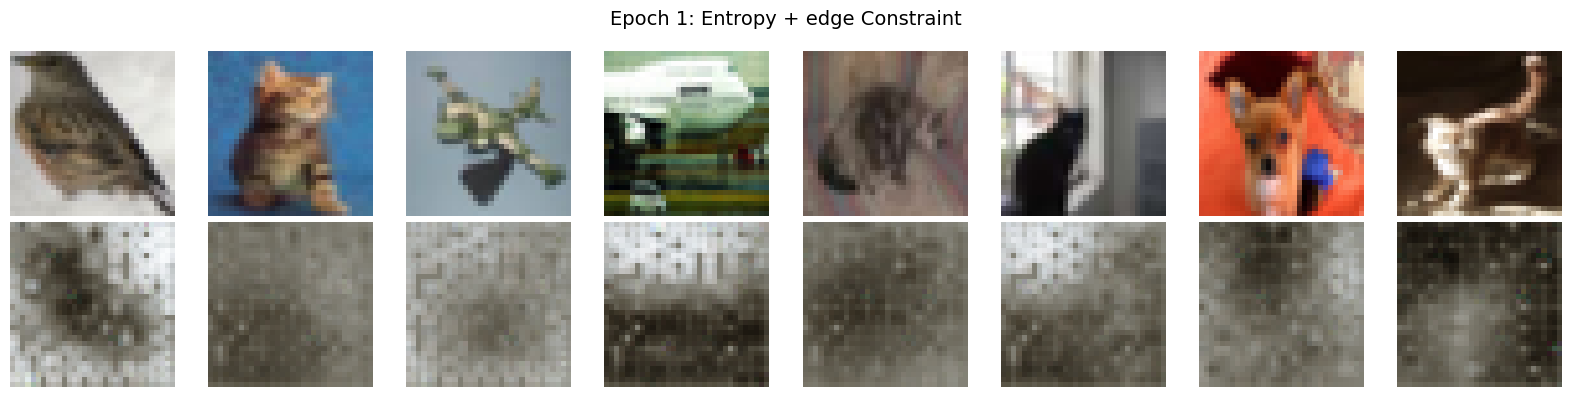

Training:   1%|▋                                                                       | 2/200 [00:17<29:31,  8.95s/it]

Epoch 002 | Entropy Loss: 0.0000 | Constraint: edge


Training:   2%|█                                                                       | 3/200 [00:26<29:22,  8.95s/it]

Epoch 003 | Entropy Loss: 0.0000 | Constraint: edge


Training:   2%|█▍                                                                      | 4/200 [00:36<29:29,  9.03s/it]

Epoch 004 | Entropy Loss: 0.0000 | Constraint: edge


Training:   2%|█▊                                                                      | 5/200 [00:45<29:30,  9.08s/it]

Epoch 005 | Entropy Loss: 0.0000 | Constraint: edge


Training:   3%|██▏                                                                     | 6/200 [00:54<29:26,  9.11s/it]

Epoch 006 | Entropy Loss: 0.0000 | Constraint: edge


Training:   4%|██▌                                                                     | 7/200 [01:03<29:08,  9.06s/it]

Epoch 007 | Entropy Loss: 0.0000 | Constraint: edge


Training:   4%|██▉                                                                     | 8/200 [01:12<29:05,  9.09s/it]

Epoch 008 | Entropy Loss: 0.0000 | Constraint: edge


Training:   4%|███▏                                                                    | 9/200 [01:21<28:50,  9.06s/it]

Epoch 009 | Entropy Loss: 0.0000 | Constraint: edge
Epoch 010 | Entropy Loss: 0.0000 | Constraint: edge


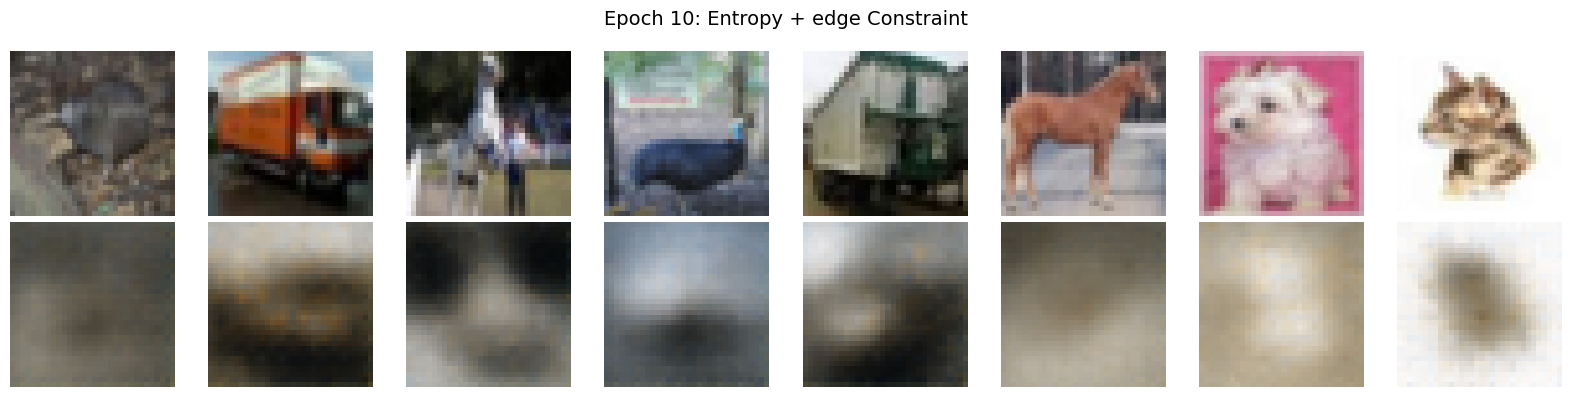

Training:   6%|███▉                                                                   | 11/200 [01:39<28:24,  9.02s/it]

Epoch 011 | Entropy Loss: 0.0000 | Constraint: edge


Training:   6%|████▎                                                                  | 12/200 [01:48<28:09,  8.99s/it]

Epoch 012 | Entropy Loss: 0.0000 | Constraint: edge


Training:   6%|████▌                                                                  | 13/200 [01:57<28:06,  9.02s/it]

Epoch 013 | Entropy Loss: 0.0000 | Constraint: edge


Training:   7%|████▉                                                                  | 14/200 [02:06<27:43,  8.95s/it]

Epoch 014 | Entropy Loss: 0.0000 | Constraint: edge


Training:   8%|█████▎                                                                 | 15/200 [02:15<27:28,  8.91s/it]

Epoch 015 | Entropy Loss: 0.0000 | Constraint: edge


Training:   8%|█████▋                                                                 | 16/200 [02:23<27:15,  8.89s/it]

Epoch 016 | Entropy Loss: 0.0000 | Constraint: edge


Training:   8%|██████                                                                 | 17/200 [02:32<27:05,  8.88s/it]

Epoch 017 | Entropy Loss: 0.0000 | Constraint: edge


Training:   9%|██████▍                                                                | 18/200 [02:41<26:54,  8.87s/it]

Epoch 018 | Entropy Loss: 0.0000 | Constraint: edge


Training:  10%|██████▋                                                                | 19/200 [02:50<26:45,  8.87s/it]

Epoch 019 | Entropy Loss: 0.0000 | Constraint: edge
Epoch 020 | Entropy Loss: 0.0000 | Constraint: edge


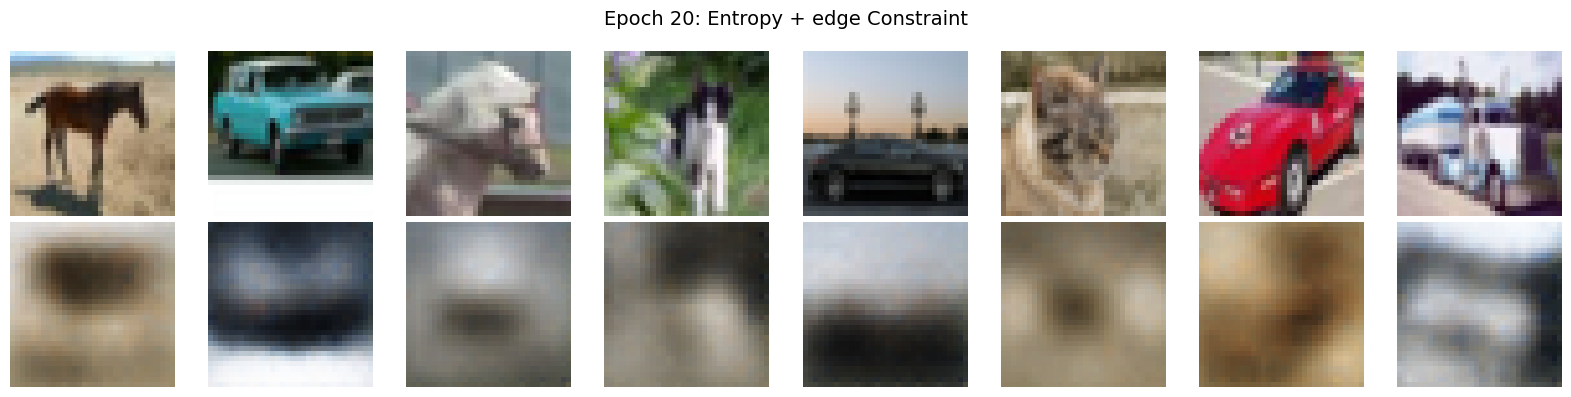

Training:  10%|███████▍                                                               | 21/200 [03:08<26:33,  8.90s/it]

Epoch 021 | Entropy Loss: 0.0000 | Constraint: edge


Training:  11%|███████▊                                                               | 22/200 [03:17<26:27,  8.92s/it]

Epoch 022 | Entropy Loss: 0.0000 | Constraint: edge


Training:  12%|████████▏                                                              | 23/200 [03:26<26:14,  8.90s/it]

Epoch 023 | Entropy Loss: 0.0000 | Constraint: edge


Training:  12%|████████▌                                                              | 24/200 [03:35<26:03,  8.88s/it]

Epoch 024 | Entropy Loss: 0.0000 | Constraint: edge


Training:  12%|████████▉                                                              | 25/200 [03:43<25:53,  8.88s/it]

Epoch 025 | Entropy Loss: 0.0000 | Constraint: edge


Training:  13%|█████████▏                                                             | 26/200 [03:52<25:54,  8.93s/it]

Epoch 026 | Entropy Loss: 0.0000 | Constraint: edge


Training:  14%|█████████▌                                                             | 27/200 [04:02<26:00,  9.02s/it]

Epoch 027 | Entropy Loss: 0.0000 | Constraint: edge


Training:  14%|█████████▉                                                             | 28/200 [04:11<25:42,  8.97s/it]

Epoch 028 | Entropy Loss: 0.0000 | Constraint: edge


Training:  14%|██████████▎                                                            | 29/200 [04:19<25:25,  8.92s/it]

Epoch 029 | Entropy Loss: 0.0000 | Constraint: edge
Epoch 030 | Entropy Loss: 0.0000 | Constraint: edge


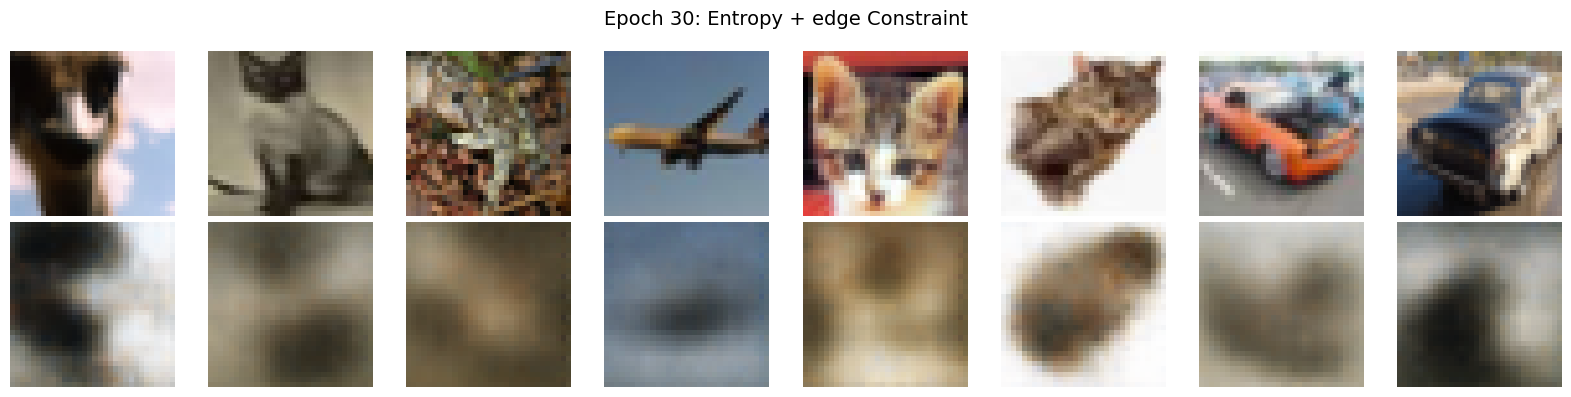

Training:  16%|███████████                                                            | 31/200 [04:38<25:40,  9.12s/it]

Epoch 031 | Entropy Loss: 0.0000 | Constraint: edge


Training:  16%|███████████▎                                                           | 32/200 [04:47<25:20,  9.05s/it]

Epoch 032 | Entropy Loss: 0.0000 | Constraint: edge


Training:  16%|███████████▋                                                           | 33/200 [04:56<25:01,  8.99s/it]

Epoch 033 | Entropy Loss: 0.0000 | Constraint: edge


Training:  17%|████████████                                                           | 34/200 [05:05<24:47,  8.96s/it]

Epoch 034 | Entropy Loss: 0.0000 | Constraint: edge


Training:  18%|████████████▍                                                          | 35/200 [05:13<24:34,  8.93s/it]

Epoch 035 | Entropy Loss: 0.0000 | Constraint: edge


Training:  18%|████████████▊                                                          | 36/200 [05:22<24:20,  8.91s/it]

Epoch 036 | Entropy Loss: 0.0000 | Constraint: edge


Training:  18%|█████████████▏                                                         | 37/200 [05:31<24:08,  8.88s/it]

Epoch 037 | Entropy Loss: 0.0000 | Constraint: edge


Training:  19%|█████████████▍                                                         | 38/200 [05:40<23:57,  8.88s/it]

Epoch 038 | Entropy Loss: 0.0000 | Constraint: edge


Training:  20%|█████████████▊                                                         | 39/200 [05:49<23:48,  8.87s/it]

Epoch 039 | Entropy Loss: 0.0000 | Constraint: edge
Epoch 040 | Entropy Loss: 0.0000 | Constraint: edge


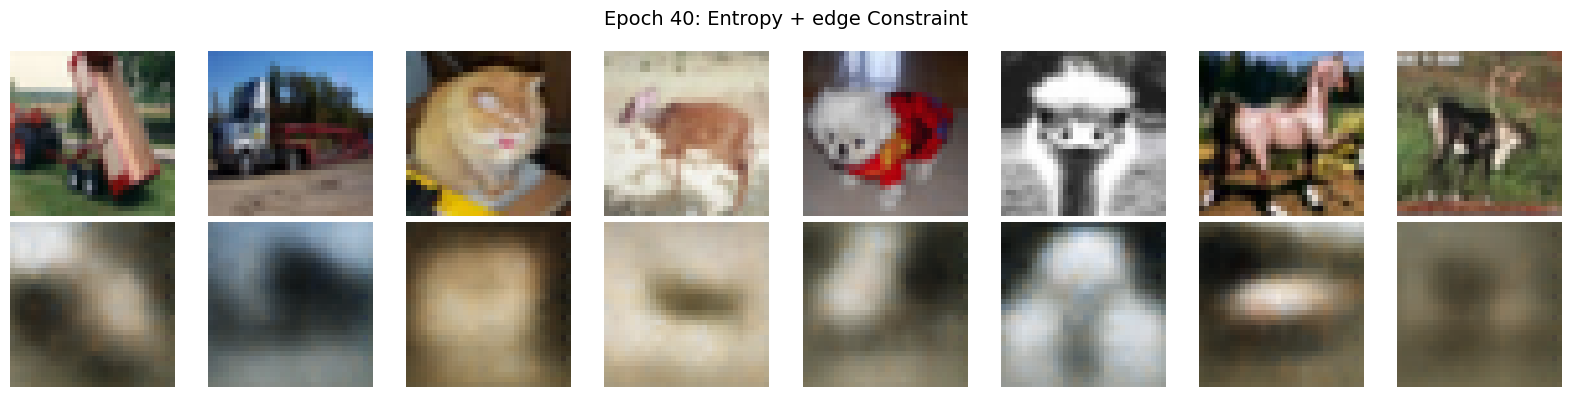

Training:  20%|██████████████▌                                                        | 41/200 [06:07<23:42,  8.95s/it]

Epoch 041 | Entropy Loss: 0.0000 | Constraint: edge


Training:  20%|██████████████▌                                                        | 41/200 [06:12<24:03,  9.08s/it]


KeyboardInterrupt: 

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# --- Config
latent_dim = 16
epochs = 200
batch_size = 128
learn_rate = 1e-3
alpha_creative = 50
alpha_rigor = 1
flip_enabled = False # Whether or not to explore by flipping entropy loss between minimize & maximize
pulse_period = 4
# Known alignment values that kinda work: 0.001, 0.005, 0.01. 0.05 seems to be too aggressive (knocks the model out of fixed point)
alignment_weight = 0.005
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda"
dataset_name="cifar"
entropy_fn = entropy_functions["softmax"]

# --- Select constraint type here
# Change to 'norm', 'jsd', 'edge', etc from dict above
structure_weights = {
    'edge': 0.15,
    'norm': 0.85
}

def get_model(dataset_name="mnist", latent_dim=16):
    if dataset_name in ["mnist", "fashion", "kmnist"]:
        # Grayscale, 28×28 → use fully connected AE
        class EntropyAutoencoder(nn.Module):
            def __init__(self, latent_dim):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(28 * 28, 128),
                    nn.ReLU(),
                    nn.Linear(128, latent_dim)
                )
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, 128),
                    nn.ReLU(),
                    nn.Linear(128, 28 * 28),
                    nn.Sigmoid(),
                    nn.Unflatten(1, (1, 28, 28))
                )

            def forward(self, x):
                z = self.encoder(x)
                out = self.decoder(z)
                return z, out

        return EntropyAutoencoder(latent_dim)

    elif dataset_name == "cifar":
        # RGB images, 32×32×3 → use a small convolutional AE
        class ConvEntropyAutoencoder(nn.Module):
            def __init__(self, latent_dim):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Conv2d(3, 32, 3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(64 * 8 * 8, latent_dim)
                )
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, 64 * 8 * 8),
                    nn.ReLU(),
                    nn.Unflatten(1, (64, 8, 8)),
                    nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
                    nn.Sigmoid()
                )

            def forward(self, x):
                z = self.encoder(x)
                out = self.decoder(z)
                return z, out

        return ConvEntropyAutoencoder(latent_dim)

    else:
        raise ValueError(f"Unsupported dataset for model: {dataset_name}")


def get_dataset(name="mnist"):
    if name in ["mnist", "fashion", "kmnist"]:
        transform = transforms.Compose([transforms.ToTensor()])
    elif name == "cifar":
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        transform = transforms.Compose([
            transforms.ToTensor(),  # Normalize to [0, 1]
        ])
    else:
        raise ValueError(f"Unsupported dataset: {name}")

    if name == "mnist":
        from torchvision.datasets import MNIST
        return MNIST(root='./data', train=True, download=True, transform=transform)

    elif name == "fashion":
        from torchvision.datasets import FashionMNIST
        return FashionMNIST(root='./data', train=True, download=True, transform=transform)

    elif name == "kmnist":
        from torchvision.datasets import KMNIST
        return KMNIST(root='./data', train=True, download=True, transform=transform)

    elif name == "cifar":
        from torchvision.datasets import CIFAR10
        return CIFAR10(root='./data', train=True, download=True, transform=transform)

    else:
        raise ValueError(f"Unsupported dataset: {name}")


def get_dataloader(dataset_name="mnist", batch_size=128, train=True, shuffle=True):
    dataset = get_dataset(dataset_name)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


def show_image(ax, img_tensor):
    img = img_tensor.cpu()
    if img.shape[0] == 1:
        # Grayscale: shape [1, H, W]
        ax.imshow(img[0], cmap='gray')
    elif img.shape[0] == 3:
        # RGB: shape [3, H, W] → [H, W, 3]
        ax.imshow(img.permute(1, 2, 0))
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")
    ax.axis('off')


# --- Model and optimizer
model = get_model(dataset_name).to(device)
optimizer = optim.Adam(model.parameters(), lr=learn_rate)


# --- Load dataset (unsupervised)
transform = transforms.Compose([transforms.ToTensor()])
train_loader = get_dataloader(dataset_name, batch_size=batch_size)


# --- Training loop
loss_trace = []

for epoch in trange(epochs, desc="Training"):
    model.train()
    if flip_enabled:
        flip = -alpha_creative if (epoch // pulse_period) % 2 == 0 else alpha_rigor
    else:
        flip = alpha_rigor
    epoch_entropy = 0.0

    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        z, x_recon = model(x)

        # Entropy loss
        e_loss = entropy_fn(z)

        # Structure loss (mixed constraints)
        structure_loss = 0.0
        for mode, weight in structure_weights.items():
            structure_fn = structure_constraints.get(mode)
            if structure_fn is None:
                raise ValueError(f"Unknown structure constraint: {mode}")
            structure_loss += weight * structure_fn(x, x_recon)

        # Final loss
        # Clean loss with one computation graph
        loss = flip * e_loss + alignment_weight * structure_loss
        loss.backward()

        optimizer.step()

        epoch_entropy += e_loss.item()

    avg_entropy = epoch_entropy / len(train_loader)
    loss_trace.append(avg_entropy)
    print(f"Epoch {epoch+1:03d} | Entropy Loss: {avg_entropy:.4f} | Constraint: {alignment_mode}")

    # Visualize every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        model.eval()
        sample_batch, _ = next(iter(train_loader))
        sample_batch = sample_batch[:8].to(device)
        with torch.no_grad():
            _, recon = model(sample_batch)

        fig, axs = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            show_image(axs[0, i], sample_batch[i])
            show_image(axs[1, i], recon[i])
        axs[0, 0].set_ylabel("Input", fontsize=12)
        axs[1, 0].set_ylabel("Reconstruction", fontsize=12)
        plt.suptitle(f"Epoch {epoch+1}: Entropy + {alignment_mode} Constraint", fontsize=14)
        plt.tight_layout()
        plt.show()


# --- Plot entropy loss over time
plt.figure(figsize=(6, 3))
plt.plot(loss_trace)
plt.title(f"Entropy Loss Over Time ({alignment_mode})")
plt.xlabel("Epoch")
plt.ylabel("Entropy Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    silhouette_score,
    classification_report,
    confusion_matrix
)

# --- Latent reduction and visualization
def reduce_latents(z_all, method="tsne", perplexity=30):
    z_np = z_all.cpu().numpy()
    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    else:
        reducer = PCA(n_components=2)
    return reducer.fit_transform(z_np)

def visualize_latent_clusters(z_all, y_all, method="tsne", title="Latent Space", perplexity=30):
    z_2d = reduce_latents(z_all, method=method, perplexity=perplexity)
    y_np = y_all.cpu().numpy()
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_np, cmap='tab10', s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Evaluation: clustering and linear separability
def compute_clustering_metrics(z_all, y_all):
    z_np = z_all.cpu().numpy()
    y_np = y_all.cpu().numpy()
    sil = silhouette_score(z_np, y_np)
    print(f"Silhouette Score: {sil:.4f}")
    return sil

def evaluate_latent_classification(z_all, y_all):
    z_np = z_all.cpu().numpy()
    y_np = y_all.cpu().numpy()
    clf = LogisticRegression(max_iter=500)
    clf.fit(z_np, y_np)
    preds = clf.predict(z_np)
    print("Classification Report on Latent Codes:")
    print(classification_report(y_np, preds, digits=3))
    return clf


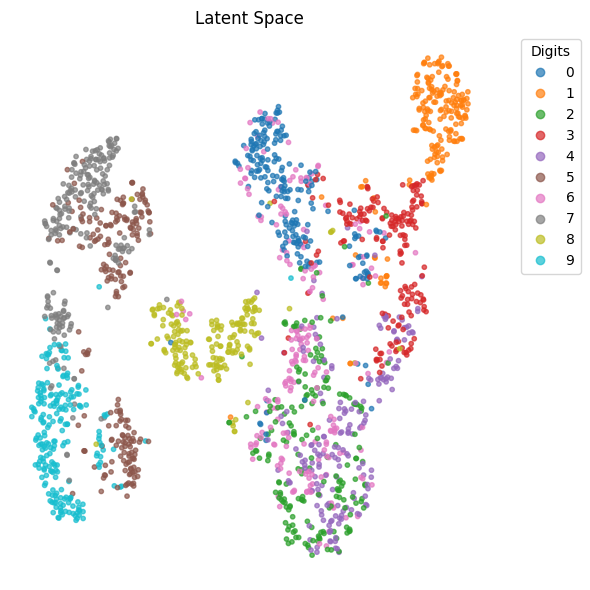

Silhouette Score: 0.0873
Classification Report on Latent Codes:
              precision    recall  f1-score   support

           0      0.774     0.837     0.805       209
           1      0.948     0.948     0.948       193
           2      0.729     0.691     0.710       191
           3      0.828     0.837     0.832       178
           4      0.689     0.734     0.711       184
           5      0.861     0.829     0.845       210
           6      0.604     0.533     0.566       212
           7      0.832     0.843     0.837       223
           8      0.953     0.979     0.966       187
           9      0.922     0.939     0.930       213

    accuracy                          0.816      2000
   macro avg      0.814     0.817     0.815      2000
weighted avg      0.814     0.816     0.814      2000



/Users/nicholasking/code/physics/ComplexityEfficiency/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
# t-SNE latent space analysis

# Collect latent representations and labels
model.eval()
z_all = []
y_all = []

with torch.no_grad():
    for x_batch, y_batch in train_loader:  # or test_loader if available
        x_batch = x_batch.to(device)
        z, _ = model(x_batch)
        z_all.append(z.cpu())
        y_all.append(y_batch)

z_all = torch.cat(z_all, dim=0)
y_all = torch.cat(y_all, dim=0)

# Subsample for faster t-SNE
sample_size = 2000
idx = torch.randperm(z_all.size(0))[:sample_size]
z_sub = z_all[idx]
y_sub = y_all[idx]

# Run latent space evaluation
visualize_latent_clusters(z_sub, y_sub, method="tsne", title="Latent Space")
_ = compute_clustering_metrics(z_sub, y_sub)
_ = evaluate_latent_classification(z_sub, y_sub)
